## Plot different sources of mortality 

In [1]:
from scipy.stats import qmc
import numpy as np

import csv
import xarray as xr
import pandas as pd
import os
import netCDF4 as nc4
import sys
import shutil
from tempfile import TemporaryFile                                                                                                                                 
import argparse                                                                                                                                                                                                                                                                                                       
import tempfile 
import random
import re

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import cm
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize
from matplotlib.colors import BoundaryNorm
import cartopy.crs as ccrs

import functions_py.fates_xarray_functions as fa

In [2]:
pftnames = ['broadleaf_evergreen_tropical_tree','needleleaf_evergreen_extratrop_tree',
         'needleleaf_colddecid_extratrop_tree','broadleaf_evergreen_extratrop_tree',
        'broadleaf_hydrodecid_tropical_tree','broadleaf_colddecid_extratrop_tree',
        'broadleaf_evergreen_extratrop_shrub','broadleaf_hydrodecid_extratrop_shrub',
        'broadleaf_colddecid_extratrop_shrub', 'arctic_c3_grass',
        'cool_c3_grasss','c4_grass']

###  Load the fates  runs

In [3]:
fates = '/pscratch/sd/j/jneedham/elm_runs/fbnc_cal/fbnc_f45_allom_CA_height_agb.Eb8be65d66e-Ffc130cb8.2023-10-11/run/fbnc_f45_allom_CA_height_agb.Eb8be65d66e-Ffc130cb8.2023-10-11.2080s.nc'
fates = xr.open_dataset(fates, decode_times=False)

time = fates.variables['time'] / 365.
cohort_size_bins = fates.variables['fates_levscls'][:]
nsizebins = len(cohort_size_bins)

#### Number of plants

In [4]:
nplant = fa.scpf_to_scls_by_pft(fates.FATES_NPLANT_SZPF, fates) 
nplant_c = fa.scpf_to_scls_by_pft(fates.FATES_NPLANT_CANOPY_SZPF, fates) 
nplant_u = fa.scpf_to_scls_by_pft(fates.FATES_NPLANT_USTORY_SZPF, fates) 

nplant = nplant  * fates.FATES_FRACTION
nplant = nplant.sum(dim='fates_levscls')
nplant_c = nplant_c * fates.FATES_FRACTION
nplant_c = nplant_c.sum(dim='fates_levscls')
nplant_u = nplant_u * fates.FATES_FRACTION
nplant_u = nplant_u.sum(dim='fates_levscls')

#### Different sources of mortality 

In [5]:
hydr_mort = fa.scpf_to_scls_by_pft(fates.FATES_MORTALITY_HYDRAULIC_SZPF, fates)
b_mort = fa.scpf_to_scls_by_pft(fates.FATES_MORTALITY_BACKGROUND_SZPF, fates) 
cstarv_mort = fa.scpf_to_scls_by_pft(fates.FATES_MORTALITY_CSTARV_SZPF, fates) 
term_mort = fa.scpf_to_scls_by_pft(fates.FATES_MORTALITY_TERMINATION_SZPF, fates) 
impact_mort = fa.scpf_to_scls_by_pft(fates.FATES_MORTALITY_IMPACT_SZPF, fates) 
freeze_mort = fa.scpf_to_scls_by_pft(fates.FATES_MORTALITY_FREEZING_SZPF, fates)
cstarv_can_mort = fa.scpf_to_scls_by_pft(fates.FATES_M3_MORTALITY_CANOPY_SZPF, fates)
cstarv_ust_mort = fa.scpf_to_scls_by_pft(fates.FATES_M3_MORTALITY_USTORY_SZPF, fates) 

#### Hydraulic mortality 

In [6]:
# multiply by fates fraction
hydr_mort = hydr_mort * fates.FATES_FRACTION
# sum over sizes
hydr_mort = hydr_mort.sum(dim='fates_levscls')
# divide by nplant
hydr_mort  = hydr_mort / nplant
# mean over time
hydr_mort = hydr_mort.mean(dim='time')


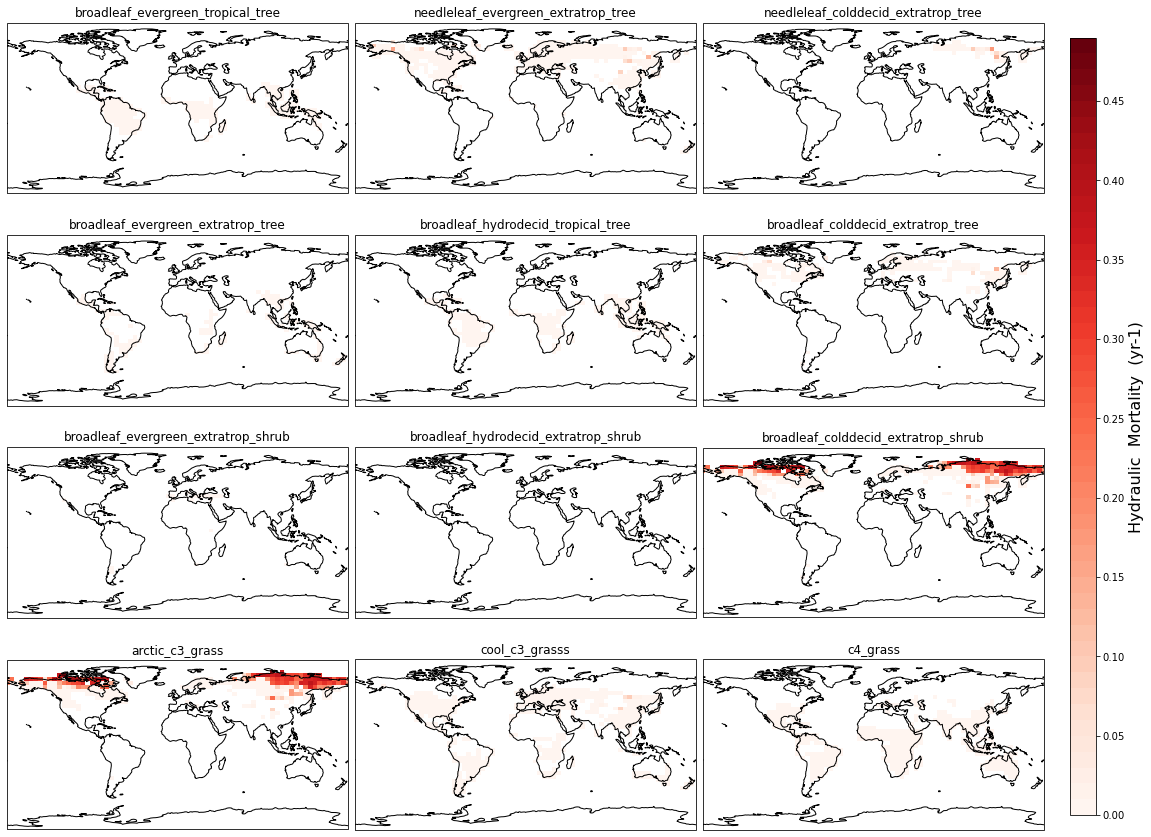

In [7]:
clevs=np.arange(0,0.5,0.01)
fig, axs = plt.subplots(nrows=4,ncols=3,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(18,18))
axs = axs.flatten()

for i in range(0,12):
    cs= hydr_mort.isel(fates_levpft=i).plot(levels=clevs,cmap='Reds',
    ax=axs[i],add_colorbar=False)
    axs[i].coastlines()
    axs[i].set_title(pftnames[i])
            
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.03)
cbar_ax = fig.add_axes([0.92, 0.275, 0.02, 0.6])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='vertical')
cbar.set_label('Hydraulic  Mortality  (yr-1)', fontsize=16)

#### Background mortality

In [8]:
b_mort = b_mort * fates.FATES_FRACTION
b_mort = b_mort.sum(dim='fates_levscls')
b_mort  = b_mort / nplant
b_mort = b_mort.mean(dim='time')

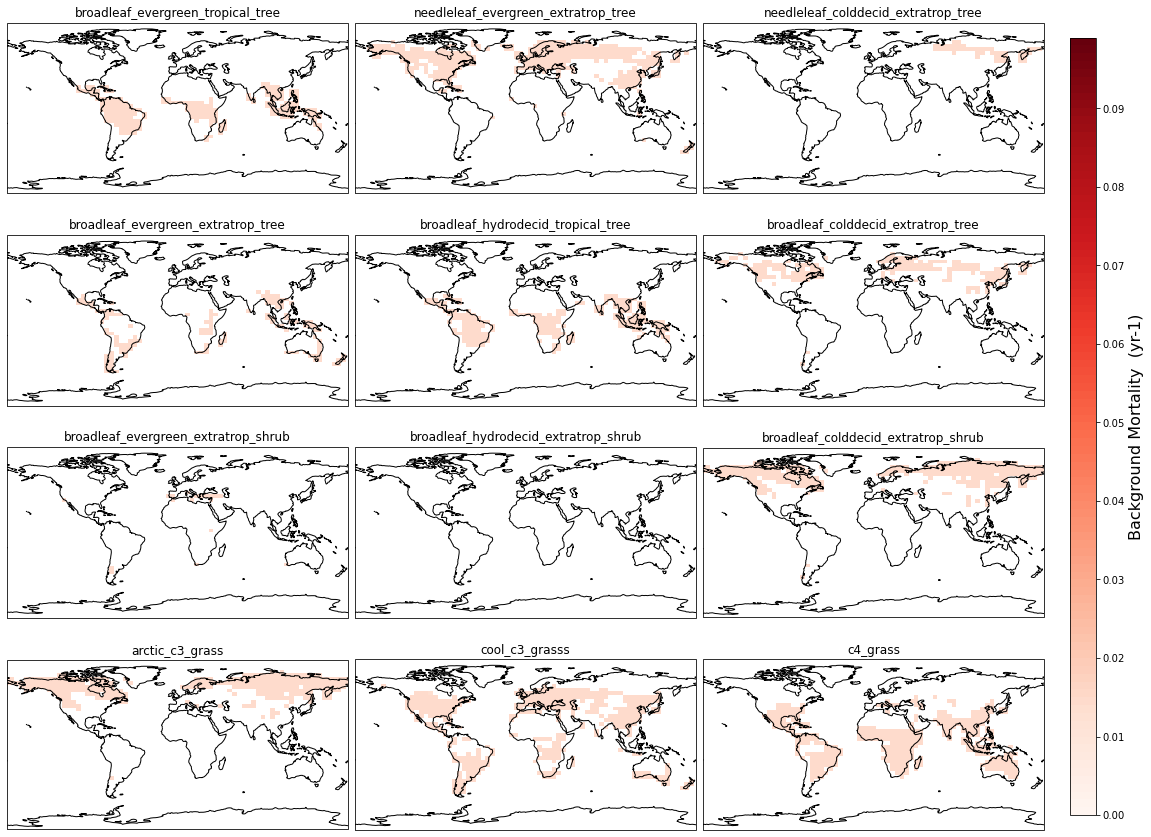

In [9]:
clevs=np.arange(0,0.1,0.001)
fig, axs = plt.subplots(nrows=4,ncols=3,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(18,18))
axs = axs.flatten()

for i in range(0,12):
    cs= b_mort.isel(fates_levpft=i).plot(levels=clevs,cmap='Reds',
    ax=axs[i],add_colorbar=False)
    axs[i].coastlines()
    axs[i].set_title(pftnames[i])
            
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.03)
cbar_ax = fig.add_axes([0.92, 0.275, 0.02, 0.6])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='vertical')
cbar.set_label('Background Mortality  (yr-1)', fontsize=16)

#### Termination mortality

In [10]:
term_mort = term_mort * fates.FATES_FRACTION
term_mort = term_mort.sum(dim='fates_levscls')
term_mort  = term_mort / nplant
term_mort = term_mort.mean(dim='time')

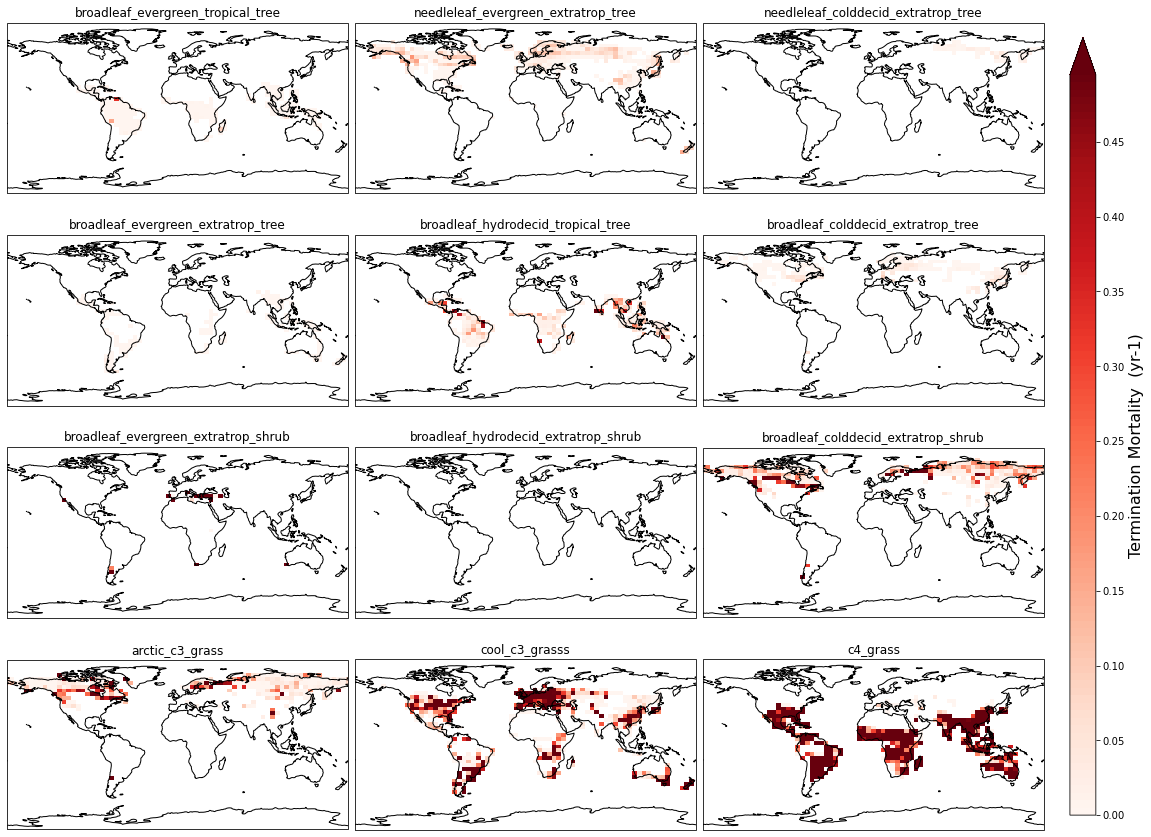

In [11]:
clevs=np.arange(0,0.5,0.005)
fig, axs = plt.subplots(nrows=4,ncols=3,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(18,18))
axs = axs.flatten()

for i in range(0,12):
    cs= term_mort.isel(fates_levpft=i).plot(levels=clevs,cmap='Reds',
    ax=axs[i],add_colorbar=False)
    axs[i].coastlines()
    axs[i].set_title(pftnames[i])
            
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.03)
cbar_ax = fig.add_axes([0.92, 0.275, 0.02, 0.6])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='vertical')
cbar.set_label('Termination Mortality  (yr-1)', fontsize=16)

#### Impact

In [12]:
impact_mort = impact_mort * fates.FATES_FRACTION
impact_mort = impact_mort.sum(dim='fates_levscls')
impact_mort  = impact_mort / nplant
impact_mort = impact_mort.mean(dim='time')

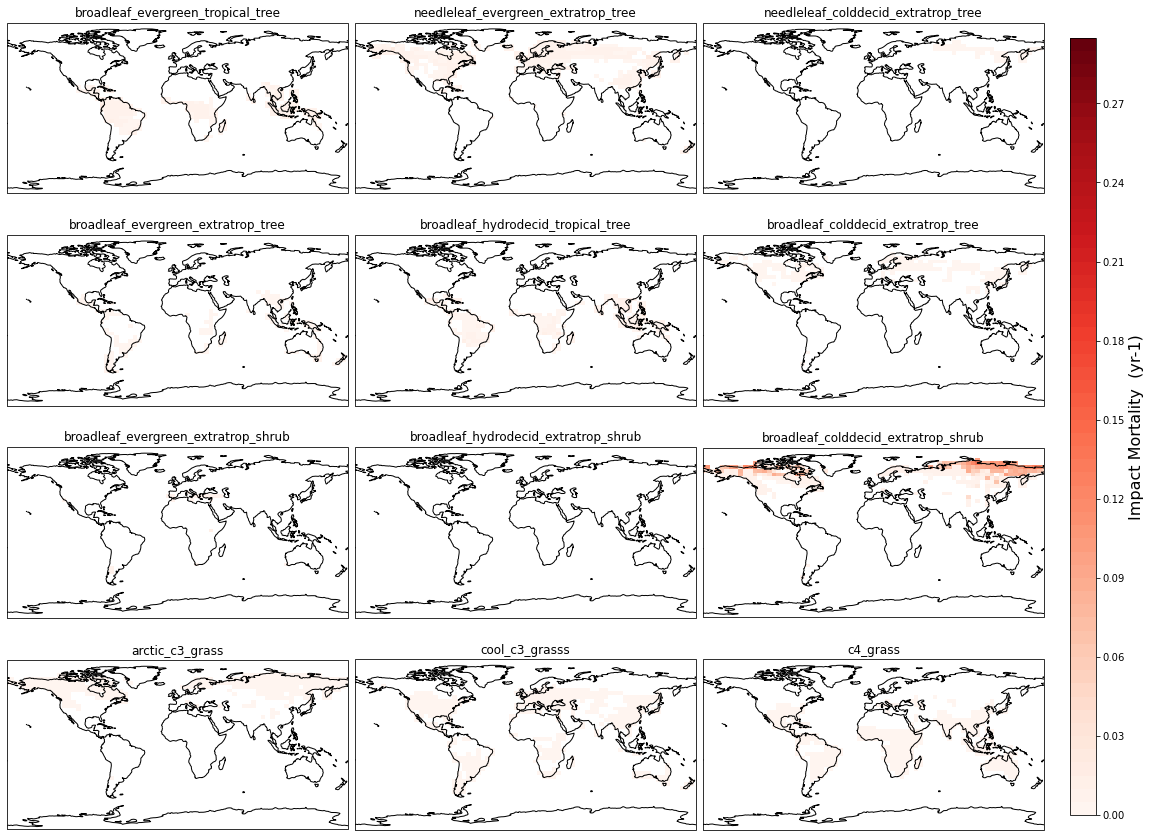

In [13]:
clevs=np.arange(0,0.3,0.005)
fig, axs = plt.subplots(nrows=4,ncols=3,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(18,18))
axs = axs.flatten()

for i in range(0,12):
    cs= impact_mort.isel(fates_levpft=i).plot(levels=clevs,cmap='Reds',
    ax=axs[i],add_colorbar=False)
    axs[i].coastlines()
    axs[i].set_title(pftnames[i])
            
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.03)
cbar_ax = fig.add_axes([0.92, 0.275, 0.02, 0.6])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='vertical')
cbar.set_label('Impact Mortality  (yr-1)', fontsize=16)

#### Freezing

In [14]:
freeze_mort = freeze_mort * fates.FATES_FRACTION
freeze_mort = freeze_mort.sum(dim='fates_levscls')
freeze_mort  = freeze_mort / nplant
freeze_mort = freeze_mort.mean(dim='time')

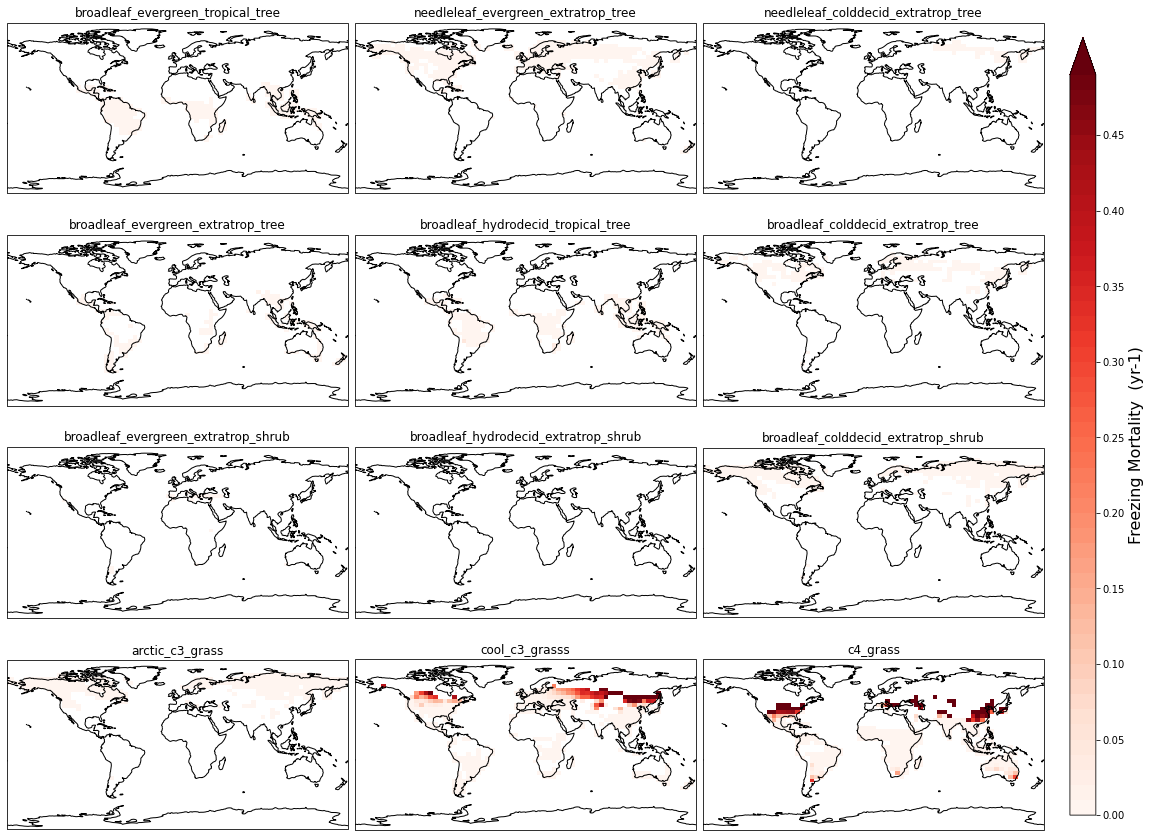

In [15]:
clevs=np.arange(0,0.5,0.01)
fig, axs = plt.subplots(nrows=4,ncols=3,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(18,18))
axs = axs.flatten()

for i in range(0,12):
    cs= freeze_mort.isel(fates_levpft=i).plot(levels=clevs,cmap='Reds',
    ax=axs[i],add_colorbar=False)
    axs[i].coastlines()
    axs[i].set_title(pftnames[i])
            
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.03)
cbar_ax = fig.add_axes([0.92, 0.275, 0.02, 0.6])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='vertical')
cbar.set_label('Freezing Mortality  (yr-1)', fontsize=16)

#### Cstarv

In [16]:
cstarv_mort = cstarv_mort * fates.FATES_FRACTION
cstarv_mort = cstarv_mort.sum(dim='fates_levscls')
cstarv_mort  = cstarv_mort / nplant
cstarv_mort = cstarv_mort.mean(dim='time')

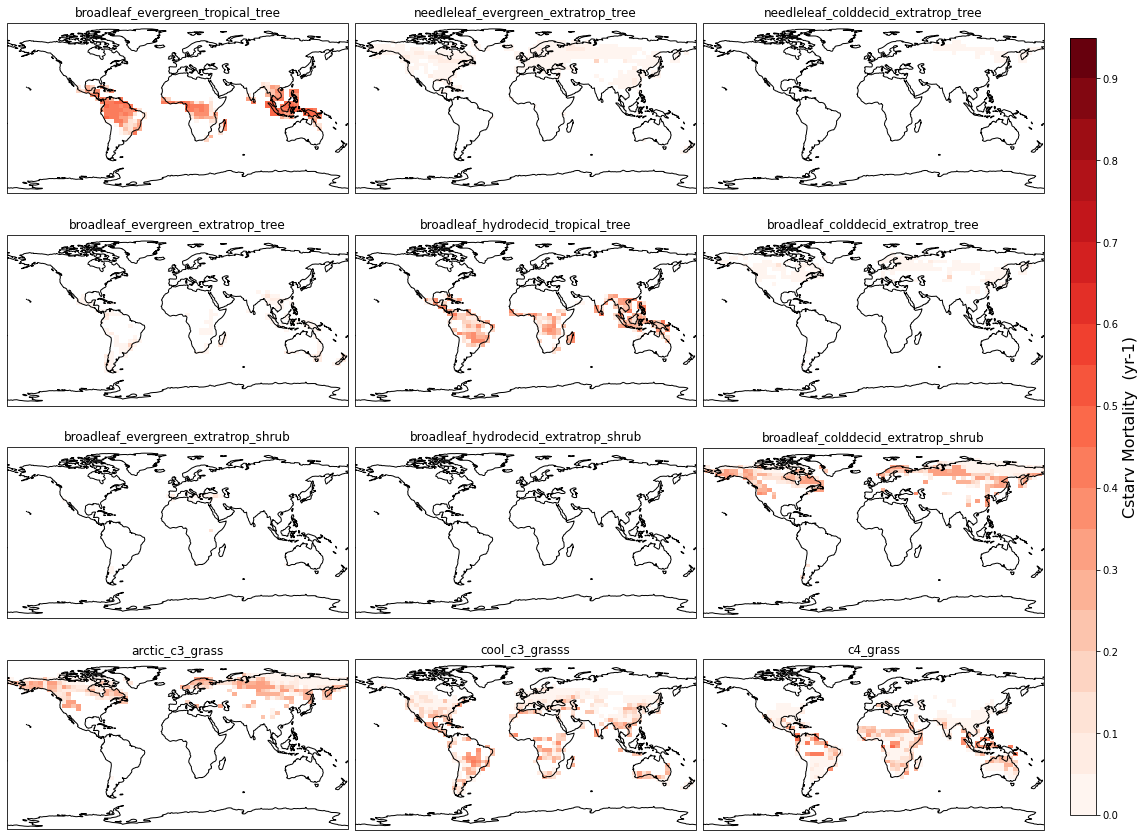

In [17]:
clevs=np.arange(0,1.0,0.05)
fig, axs = plt.subplots(nrows=4,ncols=3,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(18,18))
axs = axs.flatten()

for i in range(0,12):
    cs= cstarv_mort.isel(fates_levpft=i).plot(levels=clevs,cmap='Reds',
    ax=axs[i],add_colorbar=False)
    axs[i].coastlines()
    axs[i].set_title(pftnames[i])
            
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.03)
cbar_ax = fig.add_axes([0.92, 0.275, 0.02, 0.6])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='vertical')
cbar.set_label('Cstarv Mortality  (yr-1)', fontsize=16)

#### Canopy carbon starvation mortality 

In [18]:
cstarv_can_mort = cstarv_can_mort * fates.FATES_FRACTION
cstarv_can_mort = cstarv_can_mort.sum(dim='fates_levscls')
cstarv_can_mort  = cstarv_can_mort / nplant_c
cstarv_can_mort = cstarv_can_mort.mean(dim='time')

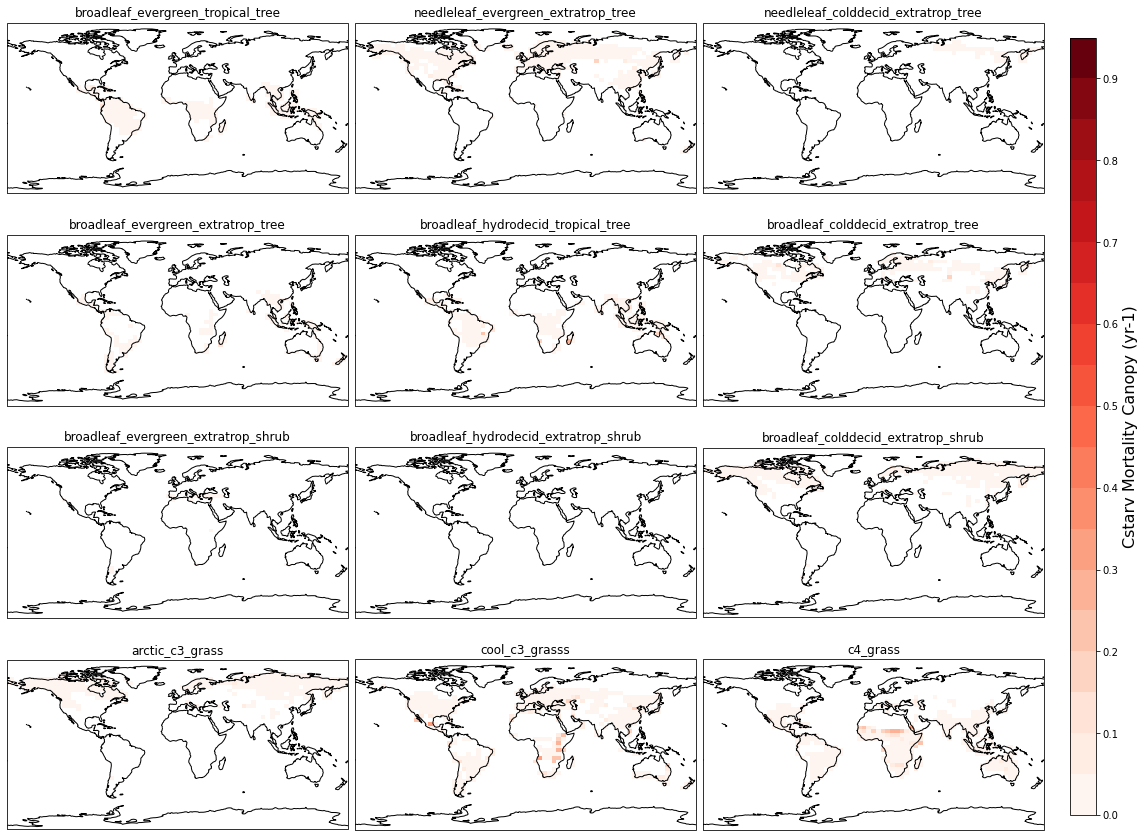

In [19]:
clevs=np.arange(0,1.0,0.05)
fig, axs = plt.subplots(nrows=4,ncols=3,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(18,18))
axs = axs.flatten()

for i in range(0,12):
    cs= cstarv_can_mort.isel(fates_levpft=i).plot(levels=clevs,cmap='Reds',
    ax=axs[i],add_colorbar=False)
    axs[i].coastlines()
    axs[i].set_title(pftnames[i])
            
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.03)
cbar_ax = fig.add_axes([0.92, 0.275, 0.02, 0.6])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='vertical')
cbar.set_label('Cstarv Mortality Canopy (yr-1)', fontsize=16)

#### Understory carbon starvation mortality 

In [20]:
cstarv_ustory_mort = cstarv_ust_mort * fates.FATES_FRACTION
cstarv_ustory_mort = cstarv_ustory_mort.sum(dim='fates_levscls')
cstarv_ustory_mort  = cstarv_ustory_mort / nplant_u
cstarv_ustory_mort = cstarv_ustory_mort.mean(dim='time')

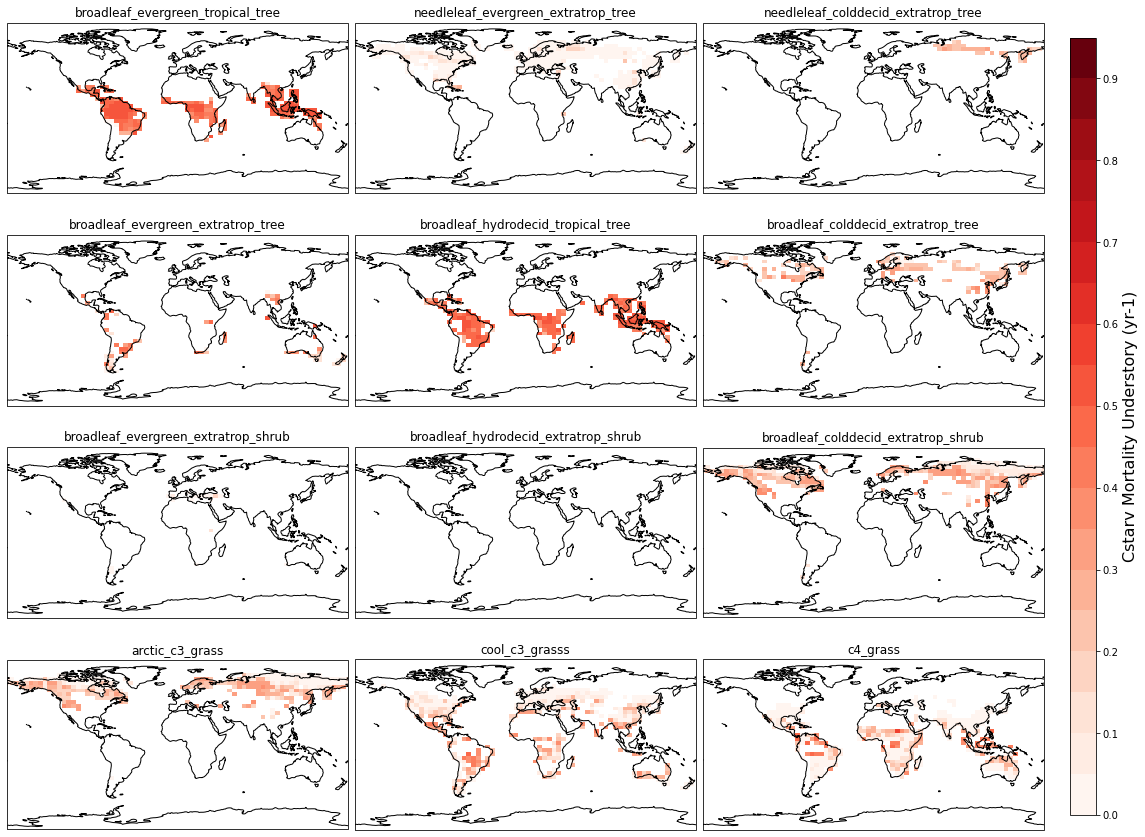

In [21]:
clevs=np.arange(0,1.0,0.05)
fig, axs = plt.subplots(nrows=4,ncols=3,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(18,18))
axs = axs.flatten()

for i in range(0,12):
    cs= cstarv_ustory_mort.isel(fates_levpft=i).plot(levels=clevs,cmap='Reds',
    ax=axs[i],add_colorbar=False)
    axs[i].coastlines()
    axs[i].set_title(pftnames[i])
            
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.03)
cbar_ax = fig.add_axes([0.92, 0.275, 0.02, 0.6])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='vertical')
cbar.set_label('Cstarv Mortality Understory (yr-1)', fontsize=16)